In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import math
import glob
from skimage import exposure 




In [2]:
def pyramid(img,  levels, sigma1 = 1, scale = 2, minSize=(16,16), step=0.5 ):
    
    #sigma2 = np.sqrt(2)*sigma1
  
    sigma2 = 2*sigma1
   
    
    image = cv2.GaussianBlur(img, ksize = (0,0),sigmaX=sigma1)
    yield image
    
    for l in range(levels):
        #image = cv2.GaussianBlur(image, ksize = (0,0), sigmaX=sigma1)
        
        image = cv2.GaussianBlur(image, ksize =(0,0),sigmaX=sigma2)
        
        dsize = (int(image.shape[1]/scale) , int(image.shape[0]/scale))
        
        image = cv2.resize(image, dsize = dsize,interpolation = cv2.INTER_AREA ) 
        
        #image = imutils.resize(image, width = int(image.shape[1]/2) ) 
        
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image
        
        
        
        
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


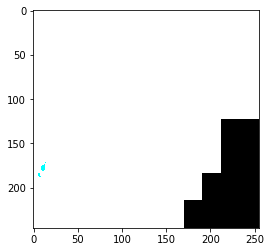

In [3]:
img_path  = "./training_folder/faces/1.jpg"

img = cv2.imread(img_path)

levels = int(np.log(max(int(img.shape[0]), int(img.shape[1]))))

pyr = tuple(pyramid(img, levels = levels))
 


rows, cols, dim = img.shape

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyr[0]

i_row = 0

for p in pyr[1:]:
    n_rows, n_cols = p.shape[:2]
                       
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

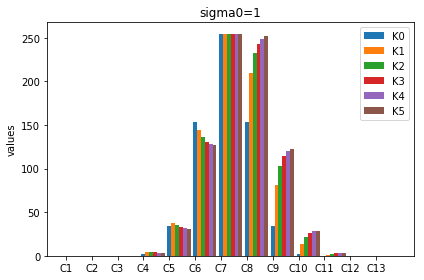

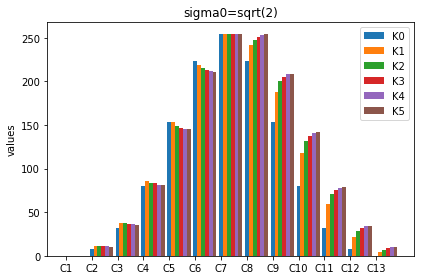

In [4]:
delta = np.zeros((512, 512), dtype=np.float32)
# Dirac
delta[255,255] = 255

# sigmas
sigma1 = 1
sigma2 = 2

# Pyramids
deltaPyramid1 = tuple(pyramid(delta, sigma1=sigma1, levels=levels))
deltaPyramid2 = tuple(pyramid(delta, sigma1=sigma2, levels=levels))

# Impulse Response for each level
ImpResp1 = np.zeros((len(deltaPyramid1), 13),dtype=float)
ImpResp2 = np.zeros((len(deltaPyramid2), 13),dtype=float)
# sigma = 1

for idx, level in enumerate(deltaPyramid1):
  
    centery = level.shape[0]//2
    centerx = level.shape[1]//2
    ImpResp1[idx,:] = exposure.rescale_intensity(level[centery-1, (centerx-7):(centerx+6)], out_range=(0,255), in_range='image').astype(np.uint8)
   

for idx, level in enumerate(deltaPyramid2):
   
    # # 2
    centery = level.shape[0]//2
    centerx = level.shape[1]//2
    ImpResp2[idx,:] = exposure.rescale_intensity(level[centery-1, (centerx-7):(centerx+6)], out_range=(0,255), in_range='image').astype(np.uint8)
   

labels = []
for c in range(13):
    label = 'C{}'.format(c+1)
    labels.append(label)

x = np.arange(len(labels))  # the label locations

width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = []
for k in range(ImpResp1.shape[0]):
    rects1.append(ax.bar(x + k*width, ImpResp1[k], width, label='K{}'.format(k)))
    

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('values')
ax.set_title('sigma0=1')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

fig2, ax2 = plt.subplots()
rects2 = []
for k in range(ImpResp1.shape[0]):
    rects2.append(ax2.bar(x + k*width, ImpResp2[k], width, label='K{}'.format(k)))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('values')
ax2.set_title('sigma0=sqrt(2)')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

fig2.tight_layout()

plt.show()


In [5]:
def build_dict_face (files_anno):
    
    
    dict_annotation_faces = {}
    for file in files_anno:

        with open(file) as file_anno:
            
            while(True):

                image_path = file_anno.readline().strip("\n")
                
                if not image_path:
                    break
                
                
               
                img =  cv2.imread("./originalPics/"+image_path+".jpg")
                
                nbre_faces = file_anno.readline()         
                
                
                for _ in range(int(nbre_faces)):

                    ellipse_coords = ellipse_coord(file_anno.readline().strip("\n"))
                    
                    rectangle_coords = coord_rectangle_faces(ellipse_coords, img.shape)
                   
                    dict_annotation_faces.setdefault(image_path, []).append(rectangle_coords)
                
            
                
   
            
    return dict_annotation_faces
                
                    

In [6]:
def ellipse_coord(coord):
    liste_coord = [float(i) for i in coord.split(" ")[:5]]
    major_axis = int(max(liste_coord[0], liste_coord[1]))
    minor_axis = int(min(liste_coord[0], liste_coord[1]))
    center_x, center_y = int(liste_coord[3]), int(liste_coord[4])
    
    return (major_axis, minor_axis, center_x, center_y)



In [7]:
def coord_rectangle_faces(ellipse_coords , img_shape):
    major_axis, minor_axis, center_x, center_y = ellipse_coords
    
    x_top_left = max(center_x - minor_axis, 0)  
    y_top_left = max(center_y - major_axis, 0)  
    x_right_bottom = min(center_x + minor_axis, img_shape[1])   
    y_right_bottom = min(center_y + major_axis, img_shape[0])  
    
    return x_top_left, y_top_left, x_right_bottom, y_right_bottom 

In [8]:
def intersection_over_union(img, current_face_box, window ):
    
    l1, t1, r1, b1 =  current_face_box
    l2, t2, r2, b2 =  window
    
    
    li = max(l1, l2)
    ti = max(t1, t2)
    ri = min(r1, r2)
    bi = min(b1, b2)
    
    inter = max(ri-li+1, 0)*max(bi-ti+1,0)
    
    area1 = (r1-l1+1)*(b1-t1+1)
    area2 = (r2-l2+1)*(b2-t2+1)
    union =  area1 + area2 - inter 
    
   
    return inter/union

In [9]:
def sliding_win_coord(window_size, coords ):
    
    x1, y1 = coords
   
    
    x2 = x1+ window_size
    y2 = y1+ window_size
    
    return x1, y1, x2, y2
    
   

In [28]:
#sizes_list = [(16,16), (19,19), (23,23), (28,28), (33,33), (40,40), (48,48), (57,57), (69,69), (83,83), (99,99)]
def build_back_fold_test_img_pyr(img_face_dict , scale_win, cptmax ):
   
    
    cpt_faces = 0
    cpt_back = 0
    

    
    for img_path, list_faces in img_face_dict.items():
    
        image =  cv2.imread("./originalPics/"+img_path+".jpg")
       
        levels = int(np.log(max(image.shape)))
   
        pyr = tuple(pyramid(image, levels = levels, scale = 2))
    
        for index, img in enumerate(pyr):
            
            idx = 1

            init_window_size =  16
            window_size = init_window_size

            step_size = window_size//8
           
            y = 0
            
            while y < img.shape[0]: 
                
               
                for x in range(0, img.shape[1], step_size):

                    img_croped_coord = sliding_win_coord( window_size, (x, y))

                    x1, y1, x2, y2 =  img_croped_coord

                    cropped_image = img[y1:y2, x1:x2]
        
                    if y2 <= img.shape[0] and x2 <= img.shape[1]: 

                        iou_max = 0

                        for face_wind in list_faces : 
                                                        
                            iou = intersection_over_union(img, face_wind, img_croped_coord )
                            
                            

                        
                        if iou_max < 0.01: 
                                
                            cv2.imwrite("./testset_pyr_folder/"+str(scale_win)+"/background/"+str(cpt_back)+'.jpg', cropped_image)
                            cpt_back +=1


                window_size = round(init_window_size *(scale_win**idx))
                
                step_size = window_size//8
                y += step_size
                idx +=1
                
            list_faces =  [tuple([x//2 for x in face_coord]) for face_coord in list_faces]
            
        if cpt_back > cptmax:
            break
            


In [12]:
#sizes_list = [(16,16), (19,19), (23,23), (28,28), (33,33), (40,40), (48,48), (57,57), (69,69), (83,83), (99,99)]
def build_face_fold_test_img(img_face_dict , scale_win ):
   
    
    cpt_faces = 0
    cpt_back = 0
    
    for img_path, list_faces in img_face_dict.items():
    
        img =  cv2.imread("./originalPics/"+img_path+".jpg")
       
        idx = 1

        init_window_size =  16
        window_size = init_window_size

        step_size = window_size//8
           
        y = 0
            
        while y < img.shape[0]: 
                
               
            for x in range(0, img.shape[1], step_size):

                img_croped_coord = sliding_win_coord( window_size, (x, y))

                x1, y1, x2, y2 =  img_croped_coord

                cropped_image = img[y1:y2, x1:x2]
        
                if y2 <= img.shape[0] and x2 <= img.shape[1]: 
                         
                        iou_max = 0

                        for face_wind in list_faces : 
                                                        
                            iou = intersection_over_union(img, face_wind, img_croped_coord )
                            
                            iou_max = max (iou, iou_max)
                            

                        if iou_max > 0.5: 
                            
                            cv2.imwrite("./testset_fold/"+str(scale_win)+"/faces/"+str(cpt_faces)+'.jpg', cropped_image)
                            cpt_faces +=1
                


            window_size = round(init_window_size *(scale_win**idx))
                
            step_size = window_size//8
            y += step_size
            idx +=1
                
    return cpt_faces

In [13]:
#sizes_list = [(16,16), (19,19), (23,23), (28,28), (33,33), (40,40), (48,48), (57,57), (69,69), (83,83), (99,99)]
def build_back_fold_test_img(img_face_dict , scale_win, cptmax ):
   
    
    cpt_faces = 0
    cpt_back = 0
    
    for img_path, list_faces in img_face_dict.items():
    
        img =  cv2.imread("./originalPics/"+img_path+".jpg")
       
        idx = 1

        init_window_size =  16
        window_size = init_window_size

        step_size = window_size//8
           
        y = 0
            
        while y < img.shape[0]: 
                
               
            for x in range(0, img.shape[1], step_size):

                img_croped_coord = sliding_win_coord( window_size, (x, y))

                x1, y1, x2, y2 =  img_croped_coord

                cropped_image = img[y1:y2, x1:x2]
        
                if y2 <= img.shape[0] and x2 <= img.shape[1]: 

                    iou_max = 0

                    for face_wind in list_faces : 
                                                        
                        iou = intersection_over_union(img, face_wind, img_croped_coord )
                            
                         
                        iou_max = max (iou, iou_max) 
                        

                        
                    if iou_max < 0.01: 
                                
                        cv2.imwrite("./testset_fold/"+str(scale_win)+"/background/"+str(cpt_back)+'.jpg', cropped_image)
                        cpt_back +=1
                            

            window_size = round(init_window_size *(scale_win**idx))
                
            step_size = window_size//8
            y += step_size
            idx +=1
                
        if cpt_back>cptmax : 
            break
    


In [27]:
#sizes_list = [(16,16), (19,19), (23,23), (28,28), (33,33), (40,40), (48,48), (57,57), (69,69), (83,83), (99,99)]
def build_face_fold_test_img_pyr(img, index, liste_faces, scale_win, cpt_faces):
   
    
    cpt_faces = 0
    cpt_back = 0
    

    
    for img_path, list_faces in img_face_dict.items():
    
        image =  cv2.imread("./originalPics/"+img_path+".jpg")
       
        levels = int(np.log(max(image.shape)))
   
        pyr = tuple(pyramid(image, levels = levels, scale = 2))
    
        for index, img in enumerate(pyr):
            
            idx = 1

            init_window_size =  16
            window_size = init_window_size

            step_size = window_size//8
           
            y = 0
            
            while y < img.shape[0]: 
                
               
                for x in range(0, img.shape[1], step_size):

                    img_croped_coord = sliding_win_coord( window_size, (x, y))

                    x1, y1, x2, y2 =  img_croped_coord

                    cropped_image = img[y1:y2, x1:x2]
        
                    if y2 <= img.shape[0] and x2 <= img.shape[1]: 
                         
                        iou_max = 0

                        for face_wind in list_faces : 
                                                        
                            iou = intersection_over_union(img, face_wind, img_croped_coord )
                            
                            
                            iou_max = max (iou, iou_max) 
                            

                        if iou_max > 0.5: 
                               
                            cv2.imwrite("./testset_pyr_folder/"+str(scale_win)+"/faces/"+str(cpt_faces)+'.jpg', cropped_image)
                            cpt_faces +=1

                window_size = round(init_window_size *(scale_win**idx))
                
                step_size = window_size//8
                y += step_size
                idx +=1
                
            list_faces =  [tuple([x//2 for x in face_coord]) for face_coord in list_faces]
        
    return cpt_faces
            


In [14]:
#Get the coordinates of the elipses and their corresponding rectangle that represents the faces in each image.

#Output: dict[img_path] = list of the coordinates of each face contained in the image

files_anno = [".\FDDB-folds\FDDB-fold-09-ellipseList.txt", ".\FDDB-folds\FDDB-fold-10-ellipseList.txt"]
img_face_dict = build_dict_face (files_anno)



In [21]:
scale_test = [1.2,1.4, 1.6, 1.8, 2]

In [16]:
# build testset folder containing faces and background  = window size scaled by "scale" by going down from top of the image to the bottom

# Number faces and background are almost the same.

for scale in scale_test:
    
    cpt = build_face_fold_test_img(img_face_dict, scale )
    build_back_fold_test_img(img_face_dict, scale, cpt )
       
        


In [29]:
# build testset folder containing faces and background  = window size scaled by "scale" by going down from top of the image to the bottom
# for all downsampled of the original image in the pyramid. Same window sizes are cropped from each level of the pyramid

# Number faces and background are almost the same.

for scale in scale_test:
    
    cpt = build_face_fold_test_img_pyr(img_face_dict, scale )
    build_back_fold_test_img_pyr(img_face_dict, scale, cpt )

In [23]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [18]:
height = 32
width = 32
img_window = (height, width, 3)
nbr_units = height*width*3

data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(height, 
                                                              width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)



model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Input(shape = img_window),
  layers.Flatten(),  
  layers.Dense(1024, kernel_initializer='he_uniform',  activation = 'relu'),
  layers.Dense(512, kernel_initializer='he_uniform',  activation = 'relu'),
  layers.Dense(2, activation = 'softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [33]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', "AUC"])
model.load_weights("model_acc.hdf5")

In [25]:
Metrics = []

In [26]:
#Precision, Recall resutls for testset using only the original images

for scale in scale_test: 

    test_ds = preprocessing.image_dataset_from_directory(
        directory = './testset_fold/'+str(scale)+'/',
        labels="inferred",
        label_mode='categorical',    
        color_mode="rgb",
        class_names = ['background', "faces"],
        batch_size=64,
        image_size=(height, width),
        shuffle=False,
    )
    
    score = model.evaluate(test_ds)
    print("Scale", str(scale), "SCORE ", str(score))
    
    files_img = glob.glob('./testset_fold/'+str(scale)+'/*/*')


    dict_class = {'faces':1, 'background': 0}

    y_pred = []
    y = []

    for i,img_file in enumerate(files_img):
        img = keras.preprocessing.image.load_img( img_file, target_size=(height, width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)

        score_eval = tf.nn.softmax(predictions[0])
        y_pred.append( np.argmax(score_eval))

        y.append( dict_class.get(img_file.split("\\")[-2]))

        
        
    print(" accuracy "+str(score[1]), end="")
    print(" f1 "+str(f1_score(y,y_pred)), end="")
    print(" recall "+str(recall_score(y,y_pred)), end = "")
    print(" precision "+str(precision_score(y,y_pred)), end = "")
    print(" AUC "+str(score[2]))

    Accuracy = score[1] 
    Precision= precision_score(y,y_pred)
    Recall = recall_score(y,y_pred)
    F1_Score = f1_score(y,y_pred)
    metric = [Accuracy ,Precision, Recall, F1_Score]

    Metrics.append(metric)



Found 7650 files belonging to 2 classes.
120/120 [==============================] - 8s 67ms/step - loss: 0.6748 - accuracy: 0.6695 - auc: 0.6519
Scale 1.2 SCORE  [0.6747666001319885, 0.6695424914360046, 0.6518977880477905]
 accuracy 0.6695424914360046 f1 0.6246299585553582 recall 0.5535152151101784 precision 0.7167119565217391 AUC 0.6518977880477905
Found 5829 files belonging to 2 classes.
92/92 [==============================] - 37s 399ms/step - loss: 0.6678 - accuracy: 0.6768 - auc: 0.6684
Scale 1.4 SCORE  [0.6678329110145569, 0.6767884492874146, 0.6683806777000427]
 accuracy 0.6767884492874146 f1 0.6135295319844677 recall 0.5548983364140481 precision 0.6860146252285192 AUC 0.6683806777000427
Found 4069 files belonging to 2 classes.
64/64 [==============================] - 25s 392ms/step - loss: 0.6732 - accuracy: 0.6562 - auc: 0.6474
Scale 1.6 SCORE  [0.673169732093811, 0.6561808586120605, 0.6473999619483948]
 accuracy 0.6561808586120605 f1 0.6011428571428571 recall 0.52997481108312

[[0.66954249 0.71671196 0.55351522 0.62462996]
 [0.67678845 0.68601463 0.55489834 0.61352953]
 [0.65618086 0.69438944 0.52997481 0.60114286]
 [0.67232454 0.6572327  0.53831294 0.59185841]
 [0.68245548 0.72075472 0.57966616 0.64255677]]


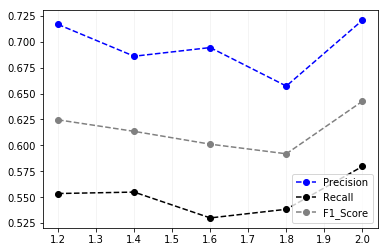

In [30]:
x = [1.2, 1.4, 1.6, 1.8, 2]
y = np.array(Metrics, dtype=float)
print(y)
# plt.plot(x, y[:,0], 'o--', color='green', label='Accuracy')

plt.plot(x, y[:,1], 'o--', color='blue', label='Precision')

plt.plot(x, y[:,2], 'o--', color='black', label='Recall')

plt.plot(x, y[:,3], 'o--', color='grey', label='F1_Score')

plt.grid(axis='x', color='0.95')
plt.legend()
plt.show()

In [31]:
#Precision, Recall resutls for testset using the pyramid of each image

Metrics = []

for scale in scale_test: 

    test_ds = preprocessing.image_dataset_from_directory(
        directory = './testset_pyr_folder/'+str(scale)+'/',
        labels="inferred",
        label_mode='categorical',    
        color_mode="rgb",
        class_names = ['background', "faces"],
        image_size=(height, width),
        shuffle=False,
    )
    
    score = model.evaluate(test_ds)
    print("Scale", str(scale), "SCORE ", str(score))
    
    files_img = glob.glob('./testset_pyr_folder/'+str(scale)+'/*/*')


    dict_class = {'faces':1, 'background': 0}

    y_pred = []
    y = []

    for i,img_file in enumerate(files_img):
        img = keras.preprocessing.image.load_img( img_file, target_size=(height, width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)

        score_eval = tf.nn.softmax(predictions[0])
        y_pred.append( np.argmax(score_eval))

        y.append( dict_class.get(img_file.split("\\")[-2]))

        
        
    print(" accuracy "+str(score[1]), end="")
    print(" f1 "+str(f1_score(y,y_pred)), end="")
    print(" recall "+str(recall_score(y,y_pred)), end = "")
    print(" precision "+str(precision_score(y,y_pred)), end = "")
    print(" AUC "+str(score[2]))

    Accuracy = score[1] 
    Precision= precision_score(y,y_pred)
    Recall = recall_score(y,y_pred)
    F1_Score = f1_score(y,y_pred)
    metric = [Accuracy ,Precision, Recall, F1_Score]

    Metrics.append(metric)



Found 31909 files belonging to 2 classes.
998/998 [==============================] - 176s 177ms/step - loss: 0.6615 - accuracy: 0.6829 - auc: 0.6855
Scale 1.2 SCORE  [0.6614767909049988, 0.6828794479370117, 0.6855100393295288]
 accuracy 0.6828794479370117 f1 0.6433431899960811 recall 0.5659395762818102 precision 0.745274453157243 AUC 0.6855100393295288
Found 21401 files belonging to 2 classes.
669/669 [==============================] - 119s 177ms/step - loss: 0.6624 - accuracy: 0.6818 - auc: 0.6824
Scale 1.4 SCORE  [0.6623618006706238, 0.6817905902862549, 0.6824281215667725]
 accuracy 0.6817905902862549 f1 0.6333816502925861 recall 0.5613283851936436 precision 0.7266568120226656 AUC 0.6824281215667725
Found 14373 files belonging to 2 classes.
450/450 [==============================] - 79s 176ms/step - loss: 0.6617 - accuracy: 0.6786 - auc: 0.6813
Scale 1.6 SCORE  [0.661737322807312, 0.6786335706710815, 0.6813015341758728]
 accuracy 0.6786335706710815 f1 0.6332987965250657 recall 0.5542

[[0.68287945 0.74527445 0.56593958 0.64334319]
 [0.68179059 0.72665681 0.56132839 0.63338165]
 [0.67863357 0.73861313 0.55426897 0.6332988 ]
 [0.6981619  0.75728373 0.55860473 0.64294549]
 [0.71651983 0.78144215 0.57519029 0.66263775]]


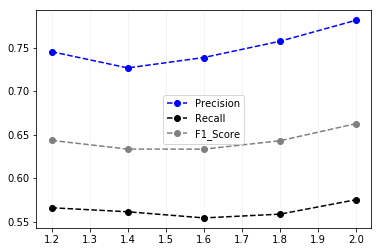

In [32]:
x = [1.2, 1.4, 1.6, 1.8, 2]
y = np.array(Metrics, dtype=float)
print(y)
# plt.plot(x, y[:,0], 'o--', color='green', label='Accuracy')

plt.plot(x, y[:,1], 'o--', color='blue', label='Precision')

plt.plot(x, y[:,2], 'o--', color='black', label='Recall')

plt.plot(x, y[:,3], 'o--', color='grey', label='F1_Score')

plt.grid(axis='x', color='0.95')
plt.legend()
plt.show()